#**Classification**

https://github.com/qizhex/Controllable-Invariance

For our classification experiments, the input is either a picture or a feature vector.
All of the three players in the minimax game are constructed by feedforward neural networks. We feed s to the encoder as an embedding vector. We use the Extended Yale B dataset [Georghiades et al., 2001] for our image
classification task. 

**Dataset source:** http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html

It comprises face images of **38 people under 5 different lighting conditions**: upper right, lower right, lower left, upper left, or the front.

* The **variable s** to be purged is the **lighting condition**. 
* The **label y** is the identity of the **person**. 


* We follow Li et al. [2014], Louizos et al. [2016]’s train/test split and **no validation** is used. 
* **38 × 5 = 190 samples** are used for training and all other **1, 096 data** points are used for testing.
* We use a one-layer neural network for the encoder and a one-layer neural network for prediction. 
* γ is set to 2. 
* The discriminator is a two-layer neural network with batch normalization. 
* The batch size is set to 16 and the hidden size is set to 100.

In [149]:
import torch
import torch.nn as nn
from torch import cuda
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as torchdata
from torch.autograd import Variable
from torchsummary import summary

import math
import time
import os
import sys
import random
import copy
from collections import deque
import cv2

import numpy as np
import pandas as pd
import json
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
%time

import time
import sklearn
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Found GPU at: {}'.format(device))

torch.set_default_tensor_type('torch.cuda.DoubleTensor')
# mount gdrive and confrim that dataset exists in this directory
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

path = 'gdrive/My Drive/Research/Projects/Classification/'

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Found GPU at: cuda:0
Mounted at /content/gdrive


## Neural_Network
Encoder, Predictor, and Discriminator

* We use a one-layer neural network for the encoder and a one-layer neural network for prediction.

* The discriminator is a two-layer neural network with batch normalization.

* The batch size is set to 16 and the hidden size is set to 100

* **one-layer neural network:** https://colab.research.google.com/github/KrishnaswamyLab/SingleCellWorkshop/blob/master/exercises/Deep_Learning/notebooks/00_Advanced_Cell_type_classification_with_neural_networks.ipynb#scrollTo=5KNIbIWld4W9

In [2]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = nn.Parameter(torch.randn(input_size, output_size).double(), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(output_size).double(), requires_grad=True)
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

### Encoder()

In [198]:
class Encoder(nn.Module):
    def __init__(self, input_dim = 10, output_dim = 10, activation_function = None):
        super(Encoder, self).__init__()
        
        # layers
        self.L1 = layer(input_dim, output_dim, activation=activation_function)

    def forward(self, X):
        # o = self.flatten(X)
        o = self.L1(X)
        # o = self.L2(o)
        return o
        
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    def flatten(self, x):
        if len(x.size()) == 3:
          B, _, _ = x.size()
        else:
          B, _, _, _ = x.size()

        return x.contiguous().view(B,-1)

### Decoder()

In [4]:
class Decoder(nn.Module):
    def __init__(self, input_dim = 1, output_dim = 3, hidden_size = 1, activation_function = None):
        super(Decoder, self).__init__()
        
        # layers
        self.L1 = layer(input_dim, hidden_size, activation = activation_function)
        self.L2 = layer(hidden_size, output_dim)
        # self.L2 = nn.Linear(num_filters, output_dum)

    def forward(self, X):
        o = self.flatten(X)
        o = self.L1(o)
        self.z = self.L2(o)
        return self.z
        
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))

    def flatten(self, x):
        # print (x.size())
        if len(x.size()) == 3:
          B, _, _ = x.size()
        elif len(x.size()) == 4:
          B, _, _, _ = x.size()
        else:
          B, _ = x.size()

        return x.contiguous().view(B,-1)

### Discriminator()

In [111]:
class Discriminator(nn.Module):
    def __init__(self, input_dim = 1, output_dim = 3, hidden_size = 1):
        super(Discriminator, self).__init__()
    
        assert (len(hidden_size) == 3)
        # layers
        self.L1 = layer(input_dim, hidden_size[0], activation=nn.Sigmoid())
        self.L2 = layer(hidden_size[0], hidden_size[1], activation=nn.Sigmoid())
        self.L3 = layer(hidden_size[1], output_dim)#, activation=nn.Sigmoid())
        self.B1 = nn.BatchNorm1d(hidden_size[1])
        # self.L4 = layer(hidden_size[2], output_dim)
        
    def forward(self, X):
        o = self.L1(X)
        o = self.L2(o)
        o = self.B1(o)
        o = self.L3(o)
        # o = self.L4(o)
        return o
        
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    def sigmoidPrime(self, s):
        # derivative of sigmoid
        return s * (1 - s)

    def flatten(self, x):
        # print (x.size())
        B, N, _, _ = x.size()
        return x.contiguous().view(B,-1)

### NMT_Mode(), Combine_model()

In [6]:
class Combine_model(nn.Module):
    def __init__(self, encoder, decoder):
        super(Combine_model, self).__init__()

        #  layer
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, X):
        o = self.encoder(X)
        o = self.decoder(o)
        return o

**NMTModel()**

Train all three components together with a gradient reversal layer
**[[Ganin and Lempitsky, 2015]](http://proceedings.mlr.press/v37/ganin15.pdf)**

* The proposed architecture includes a **deep feature extractor (green)** and a **deep label predictor (blue)**, which together form a standard feed-forward architecture. 

* Unsupervised domain adaptation is achieved by adding **a domain classifier (red)** connected to the feature extractor via a **gradient reversal layer** that **multiplies the gradient by a certain negative constant** during the backpropagationbased training. 

* Otherwise, the training proceeds in a standard way and minimizes the label prediction loss (for source examples) and
the domain classification loss (for all samples). 

* Gradient reversal ensures that the feature distributions over the two domains are made similar (as indistinguishable as possible for the domain classifier), thus resulting in the domain-invariant features.

In [7]:
class NMTModel(nn.Module):

    def __init__(self, encoder, decoder, discriminator, generator = 0):
        super(NMTModel, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        self.generator = generator
        self.dec_grad_norm = 0        

    def get_disc_parameters(self):
        for comp in [self.discriminator]:
            if comp is None:
                continue
            for p in comp.parameters():
                yield p

    def get_encoder_parameters(self):
        for comp in [self.encoder]:
            for p in comp.parameters():
                yield p

    def make_init_decoder_output(self, context):
        batch_size = context.size(1)
        h_size = [batch_size]
        return Variable(context.data.new(*h_size).zero_(), requires_grad=False)

    def forward(self, input):

        context = self.encoder(input) #input to encoder 
        # init_output = self.make_init_decoder_output(context) #input to decoder?

        #  how does it works     
        dec_norm = []
        # dec_context_variable.register_hook(dec_wrapper(dec_norm))

        #  output of discriminator
        disc_out = self.discriminator(context)
                
        #  output of decoder
        out = self.decoder(context) #dec_context_variable)


        return out, disc_out, dec_norm
        

def dec_wrapper(norm):
    def hook_func(grad):
        norm.append(math.pow(grad.norm().data[0], 2))
        pass
    return hook_func

NMTCriterion()

https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E5%9F%BA%E7%A4%8E%E4%BB%8B%E7%B4%B9-%E6%90%8D%E5%A4%B1%E5%87%BD%E6%95%B8-loss-function-2dcac5ebb6cb

**nn.NLLLoss** calculates the probability of the correct label.  --> probability(correct_label)

e.g. [0.1, 0.8, 0.1]

**nn.CrossEntropLoss** It is: log(probability(correct_label)), summed over the minibatch. So output is between 0 and 2 (since you have 3 labels).

e.g. [1]

In [8]:
def NMTCriterion(the_type = 'cel', target_size = 2):
    
    # weight = torch.Tensor(weight)
    if the_type == 'cel':
      crit = nn.CrossEntropyLoss().double()
    # elif the_type == 'cross_entropy_loss_logit':
    #   crit = the_typ
    else:
      crit = nn.NLLLoss().double()
      print ('nllloss')

    return crit

https://discuss.pytorch.org/t/how-to-print-the-computed-gradient-values-for-a-network/34179

weight.grad.data[0] -> gradient  dL/dweight

a.resgister_hook(lambda grad: print(grad)) --> get the  dL/da

In [9]:
# encoder = Encoder(1,100,50,3)
# predictor = Decoder(50,30,38,3, 38*188*164)
# discrminator = Discriminator(50,5,30, 20,3, 186*162*20)

# models = [NMTModel(encoder, predictor, discrminator).float()]
# summary(models[0], (1,192,168),16)

### Optimizer()

In [10]:
class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = optim.Adam(self.params, lr=self.lr, betas=(self.adam_momentum, 0.999))
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, disc_params, enc_params, method, max_grad_norm = 5, lr = 0.001, lr_decay=1, start_decay_at=None, adam_momentum=0.9):
        self.params = list(params)  # careful: params may be a generator
        self.disc_params = list(disc_params)
        self.encoder_params = list(enc_params)
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False
        self.adam_momentum = adam_momentum
        self._makeOptimizer()

    def step_all(self):
        #  Compute gradients norm.
        #     Gradients are not “initialize”, they are equal to None until you backpropagate something.
        #     You can access to gradients by doing w.grad
        #     However nothing will be returned as there are no gradients… (unless you backprop an scalar which involves w)
        
        enc_grad_norm = 0
        # for param in self.disc_params: # encoder
        #     enc_grad_norm += math.pow(param.grad.data.norm(), 2)   
        # enc_grad_norm = math.sqrt(enc_grad_norm)

        grad_norm = 0
        # for param in self.params: # model parameter
        #     grad_norm += math.pow(param.grad.data.norm(), 2)
        # # grad_norm = math.sqrt(grad_norm)

        # # shrinkage = self.max_grad_norm / grad_norm
        # for param in self.params:
        #     if shrinkage < 1:
        #         param.grad.data.mul_(shrinkage)
        self.optimizer.step()
        
        return enc_grad_norm, grad_norm

    def step_disc_enc(self, disc_lambda):
        # Compute gradients norm.
        enc_grad_norm = 0
        grad_norm = 0

        for param in self.encoder_params:
            n = math.pow(param.grad.data.norm(), 2)
            if math.fabs(disc_lambda) > 1e-5:
                n *= math.pow(disc_lambda, 2)
            param.grad.data.mul_(-disc_lambda)
            enc_grad_norm += n
            grad_norm += n
        enc_grad_norm = math.sqrt(enc_grad_norm)
        for param in self.disc_params:
            grad_norm += math.pow(param.grad.data.norm(), 2)
        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.encoder_params + self.disc_params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return enc_grad_norm, grad_norm

    # decay learning rate if val perf does not improve or we hit the start_decay_at limit
    # def updateLearningRate(self, ppl, epoch):

    #     if self.start_decay_at is not None and epoch >= self.start_decay_at:
    #         self.start_decay = True
    #     if self.last_ppl is not None and ppl > self.last_ppl:
    #         self.start_decay = True

    #     if self.start_decay:
    #         self.lr = self.lr * self.lr_decay
    #         print("Decaying learning rate to %g" % self.lr)

    #     self.last_ppl = ppl
    #     self._makeOptimizer()

**Training**

train all three components together with a gradient reversal layer
[Ganin and Lempitsky, 2015]

## Combination_Loss()

https://discuss.pytorch.org/t/basics-of-loss-backward/14069

This won’t actually compute any gradients. It detaches loss from the rest of the computation graph; you’re creating a new node that is loss2 = Variable(loss.data) that is not connected to the rest of the computation graph.

https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method

As long as you use retain_graph=True in your backward method, you can do backward any time you want

https://stackoverflow.com/questions/54754153/autograd-grad-for-tensor-in-pytorch



In [11]:
def Combination_Loss(outputs, public_label, disc_out, sensitive_label, criterion, discriminator_criterion, eval=False, print_prob=False, dicts=None):

    #  calculate encoder and decoder loss
    outputs = Variable(outputs.data, requires_grad=(not eval)).contiguous() # continguous before linear layer?    
    dec_loss = criterion(outputs, public_label.long()) # calculate the total loss
    
    if not eval:
      dec_loss.backward()

    #  get the decoder gradient
    dec_grad_output = None if outputs.grad is None else outputs.grad.data
      
    #  discrimiinator loss
    disc_out = Variable(disc_out.data, requires_grad=(not eval)).contiguous()
    disc_loss = gamma* discriminator_criterion(disc_out, sensitive_label.long()) # calculate the total loss
    
    if not eval:
      disc_loss.backward() # division

    #  get the discrminator gradient
    grad_disc_out = None if disc_out.grad is None else disc_out.grad.data

    return dec_loss, disc_loss, dec_grad_output, grad_disc_out

## prediction(), evaluation()

In [12]:
def prediction(output, label):
  scores = F.softmax(output, dim = 1)
  probability, indecies = torch.max(scores,dim=1)
  train_total = label.size(0)
  train_correct = np.sum(np.array(label.cpu())==np.array(indecies.cpu()))

  return train_correct, train_total, indecies

Evaluation()

In [13]:
def evaluation(models, criterion, discriminator_criterion, valid_loader, model_index = 0):

    total_loss = 0
    total_disc_acc = 0
    total_sent = 0
    total_correct, total_number = 0, 0
    count = 0

    #  set to evaluation mode
    models[model_index].eval()

    for i, (data, labels) in enumerate(valid_loader):
        
        # labels
        data = Variable(data).double().to(device)
        public_label = Variable(labels[:,0]).to(device)
        sensitive_label = Variable(labels[:,1]).to(device)

        # decoder and discriminator outputs
        outputs, disc_out, dec_norm = models[0](data)

        # loss function
        dec_loss, _, _, _ = Combination_Loss(outputs, public_label, disc_out, sensitive_label,
                                             criterion, discriminator_criterion, eval = True, print_prob=False) 
       
        # prediction 
        correct, _, _ = prediction(outputs, public_label.long())
        disc_correct, _, _ = prediction(disc_out, sensitive_label.long())
        total_correct += correct

        # accumulate results
        total_loss += dec_loss
        total_disc_acc += disc_correct
        total_sent += data.size(0)
        count += 1
    
    #  retrun to train mode
    models[model_index].train()

    return total_loss/count, total_correct/total_sent, total_disc_acc/ total_sent

## Train_Model(), Test_Model()

they split the loss function to a subgraph 

--> calculate the graidents of the subgraph and the backprop this obtained gradient back to original model.


In [14]:
def Test_Model(models, test_loader, printing = 10, verbose = False):

  total_correct, total_disc_acc, total_sent = 0, 0, 0

  for i, (data, labels) in enumerate(test_loader):

          # labels
          data = data.double().to(device)
          public_label = labels[:,0].to(device)
          sensitive_label = labels[:,1].to(device)

          # decoder and discriminator outputs
          outputs, disc_out, dec_norm = models[0](data)

          # prediction 
          correct, _, indecies = prediction(outputs, public_label)
          disc_correct, _, disc_indecies = prediction(disc_out, sensitive_label)
          total_correct += correct

          # accumulate results
          total_disc_acc += disc_correct
          total_sent += public_label.size(0)

          if verbose and i == 0:
            print('\npublic   ',public_label[:printing])
            print('pub pred.',indecies[:printing])
            print('sensitive',sensitive_label[:printing])
            print('sen pred.',disc_indecies[:printing])

  dec_acc = total_correct/total_sent
  dis_acc = total_disc_acc/ total_sent
  print('Test Accuracies:: (pub)dec_acc: %f, (sen)disc_acc: %f' % (total_correct/total_sent, total_disc_acc/ total_sent))
  print()

  return dec_acc, dis_acc

train_model()

In [15]:
def Train_Model(models, train_loader, valid_loader, loss_type, optims, epochs, batch_size, print_every = 10, verbose = False):

    #  set to training mode
    for single_model in models:
        single_model.double().train()

    # define criterion/loss function
    print ('* Predictor     Criterion:', loss_type)
    criterion = NMTCriterion(loss_type)
    print ('* Discriminator Criterion:', loss_type, '\n')
    discriminator_criterion = NMTCriterion(loss_type) #nn.NLLLoss(reduction='sum') #cuda

    history_valid = []
    count = 0

    for epoch in range(epochs):

        if verbose:
          print ('\nEpoch %i:' %(epoch+1))

        #  ================================= Training =================================  #

        total_loss, total_disc_acc = 0, 0
        total_sent, total_dec_acc = 0, 0
        train_total, train_correct = 0, 0
        total = 0

        for k, (data, labels) in enumerate(train_loader):
            
            model_index = 0
            data = data.double().to(device)
            public_label = Variable(labels[:,0]).double().to(device)     # index 0 = public_label
            sensitive_label = Variable(labels[:,1]).double().to(device)  # index 1 = sensitive_label

            #  create zero gradients
            models[model_index].zero_grad()

            #  forward propagation
            outputs, disc_out, dec_norm = models[model_index](data)

            #  calculate loss + gradients until the output layer
            dec_loss, disc_loss, grad_dec_output, grad_disc_output = Combination_Loss(outputs, public_label, disc_out, sensitive_label,
                                                                                criterion, discriminator_criterion, print_prob=False)            

            #  backward propagation the rest of the layers with the above graidents
            torch.autograd.backward([outputs, disc_out], [grad_dec_output, grad_disc_output])

            _, grad_norm = optims[model_index].step_all()

            #  calculate accuracy
            dec_correct, dec_total, dec_indecies = prediction(outputs, public_label)
            disc_correct, disc_total, disc_indecies = prediction(disc_out, sensitive_label)

            #  save loss results
            total_dec_acc += dec_correct
            total_disc_acc += disc_correct
            total_sent += data.size(0)
            total_loss += dec_loss
            total += 1
            count += 1

            if count % print_every == 0:
                print('loss: %f, dec_acc: %f, disc_acc: %3f'% (dec_loss, dec_correct/dec_total, disc_correct/disc_total))
                

            # if verbose and (i % print_every == 0):
            #     if verbose == 'dec':
            #       print('decoder output:\n', outputs[:printing])
            #       print('decoder  grad.:\n', grad_disc_output)
            #       # print('decoder weight:\n', models[0].decoder.z7)
            #     else:
            #       print('disc gradient:\n', grad_disc_output[:printing])
            #       print('disc  weights:\n', models[0].discriminator.z7[:printing])
            #       # print('input bacth data:\n', data)
            #       # print('discrimantor output:\n', disc_out)
            
            # if verbose and (i % print_every == 0):
            #     if verbose == 'dec':
            #       print ('decoder pred:', dec_indecies[:printing])
            #       print ('public label:', public_label[:printing])
            #       print ('decoder accuracy:', dec_correct/dec_total)
            #     else:
            #       print ('discriman predic:', disc_indecies[:printing])
            #       print ('sensitive labels:', sensitive_label[:printing])
            #       print ('discriman accura:', disc_correct/disc_total, '\n')


        train_loss, dec_acc, disc_acc = float(total_loss)/float(total), total_dec_acc/total_sent, total_disc_acc / total_sent

        #  ================================= Validation =================================  #

        valid_loss, valid_dec_acc, valid_disc_acc = evaluation(models, criterion, discriminator_criterion, valid_loader)

        if verbose: # and (epoch % print_every == 0):
            print('\nTrain loss: %f, (pub)dec_acc: %f, (sen)disc_acc: %f'%(train_loss, dec_acc, disc_acc))
            print('Valid loss: %f, (pub)dec_acc: %f, (sen)disc_acc: %f' % (valid_loss, valid_dec_acc, valid_disc_acc))


        # #  (3) maybe update the learning rate
        # if opt.optim == 'sgd':
        #     for single_optim in optims:
        #         single_optim.updateLearningRate(valid_loss, epoch)

        history_valid.append(valid_loss)

    return history_valid
      

## main()

In [16]:
def main(train_loader, valid_loader, encoder, predictor, discrminator, loss_type = 0, learning_rate = 0.01, batch_size = 16, epochs = 10, print_every = 10, verbose = False):

    #  model
    print ('Loading Model...')
    models = [NMTModel(encoder, predictor, discrminator).double()]

    if iterate == 0:
      summary(models[0].float(), (1, input_size))
      models[0].double()
          
    #  optimizor
    print ('Loading Optimizor...')

    for model in models:
        optims = [Optim(model.parameters(), model.get_disc_parameters(), model.get_encoder_parameters(), 'adam', lr = learning_rate)]

        # https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073
        # for p in model.get_disc_parameters():
        #     p.data.uniform_(-1, 1)

    nParams = sum([p.nelement() for model in models for p in model.parameters()])
    print('* number of parameters: %d' % nParams)

    #  train
    print ('\nTraining Model....')
    history_valid = Train_Model(models, train_loader, valid_loader, loss_type, optims, epochs, batch_size, print_every, verbose)

    return models, history_valid

# Original Functions

In [287]:
def original_training(model, train_loader, valid_loader, label_index = 0, gamma = 1.0, weight = 0, learning_rate = 0.01, epochs = 10, batch_size = 10, print_every = 10, printing = True):

    #  set the model to type DoubleTensor
    model.double()
    print ('\nTraining...  Label:', label_index)
    
    #  set up biased loss for biased dataset 
    weight = torch.Tensor([1.0,1.0]).double() if weight == 0 else torch.Tensor(weight).double()

    #  define loss function and optimizoe
    loss_fn = nn.CrossEntropyLoss(weight)
    optimiztor = optim.Adam(model.parameters(), lr= learning_rate)

    count = 0
    loss_list, valid_loss_hist, iteration_list, accuracy_list = [], [], [], []
    valid_acc_hist, train_acc_hist= [], []

    # START TRAINING ====================================================================
    for epcoh in range(epochs):

        if printing:
          print('Epoch: {}/{}'.format(epcoh+1, epochs))
        
        train_total = 0
        train_correct = 0

        for i, (data, labels) in enumerate(train_loader):

          #  read data to the device
          data = data.double().to(device)
          label = labels[:,label_index].double().to(device)     # index 0 = public_label

          #  create zero gradients
          model.zero_grad()

          #  forward propagation
          prediction = model(data)

          #  calculate gradients and loss
          loss = gamma * loss_fn(prediction, label.long())  # calculate loss        
          loss.backward()                                   # backward propagation to get graidents

          if count % print_every == 0:
            print('loss: {}'.format(loss))

          #  apply gradients
          optimiztor.step()
        
          #  calculate training accuracy
          scores = F.softmax(prediction, dim=1)
          probability, indecies = torch.max(scores,dim=1)
          train_total += label.size(0)
          train_correct += np.sum(np.array(label.cpu())==np.array(indecies.cpu()))
          # print('label  :',label)
          # print('predict:', indecies)

          count += 1

          #  Calculate Validation ==================================================     
          if count % 10 == 0 and valid_loader:
              correct = 0
              valid_total = 0

              for data, labels in valid_loader:
                  
                  #  Load Data frmo validation dataset
                  data = data.double().to(device)
                  label = labels[:,label_index].double().to(device)

                  #  Prediction
                  y_pred = model(data)
                  valid_loss = loss_fn(y_pred, label.long())

                  #  Get predictions probabilities using softmax
                  scores = F.softmax(y_pred, dim=1)
                  probability, indecies = torch.max(scores,dim=1)

                  #  Total number of labels
                  valid_total += label.size(0)
                  correct += np.sum(np.array(label.cpu())==np.array(indecies.cpu()))

              valid_loss_hist.append(valid_loss.data)
              valid_acc = correct / float(valid_total)

              # store loss and iteration
              loss_list.append(loss.data)
              iteration_list.append(count)
              valid_acc_hist.append(valid_acc)

        #  End Calculate Validation ================================================     
        
        train_acc = train_correct / float(train_total)
        train_acc_hist.append(train_acc)

        if printing:
          print('Training Accuract: {}'.format(train_acc))
          print('Validation Accuracy: {}'.format(valid_acc)) if valid_loader else None


In [308]:
def original_testing(model, test_loader, label_index, printing = True, printing_length = 10):

    test_total, test_correct = 0, 0

    for i, (data, labels) in enumerate(test_loader):

        data = Variable(data).to(device)
        label = Variable(labels[:,label_index]).to(device)     # index 0 = public_label

        #  forward propagation
        prediction = model(data)

        #  calculate the accuracy
        scores = F.softmax(prediction, dim=1)
        probability, indecies = torch.max(scores,dim=1)
        test_total += label.size(0)
        test_correct += np.sum(np.array(label.cpu())==np.array(indecies.cpu()))

        if i == 0 and printing:
          print('\nReal label:', label[:printing_length])
          print('Pred label:', indecies[:printing_length])

    test_acc = test_correct / float(test_total)
    print('Test Accuracy: {}'.format(test_acc), '(total:%s)\n'%(test_total))

    return test_acc

In [315]:
def loading_data(cleandata, cleanlabel, test_percent = 0.13, valid_precent = 0.1, shuffling = False, printing = True, valid_data = True, test_data = True):

    print('Loading Dataset...')
    if test_data:
      train_x, test_x, train_y, test_y = train_test_split(cleandata, cleanlabel, test_size= test_percent, random_state=42)
    else:
      train_x, train_y = cleandata, cleanlabel

    if valid_data:
      train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size= valid_precent, random_state=42)

    if printing:
      print('   train dataset:', np.shape(train_x), np.shape(train_y))
      if valid_data:
        print('   valid dataset:', np.shape(valid_x), np.shape(valid_y))
      if test_data:
        print('   test  dataset:', np.shape(test_x), np.shape(test_y))

    # training dataset
    train_x, train_y = torch.from_numpy(train_x).double(), torch.from_numpy(train_y)
    train_ds = torchdata.TensorDataset(train_x, train_y)
    train_loader = torchdata.DataLoader(train_ds, batch_size=batch_size, shuffle=shuffling)

    #  testing dataset
    if test_data:
      test_x, test_y = torch.from_numpy(test_x).double(), torch.from_numpy(test_y)
      test_ds = torchdata.TensorDataset(test_x, test_y)
      test_loader = torchdata.DataLoader(test_ds, batch_size=batch_size, shuffle=shuffling)
    else: 
      test_loader = []

    # validation dataset
    if valid_data:
      valid_x, valid_y = torch.from_numpy(valid_x).double(), torch.from_numpy(valid_y)
      valid_ds = torchdata.TensorDataset(valid_x, valid_y)
      valid_loader = torchdata.DataLoader(valid_ds, batch_size=batch_size, shuffle=shuffling)
    else:
      valid_loader = []

    return train_loader, valid_loader, test_loader

# **German Dataset**

In [188]:
#unit deivation      
def StdScaler(data):
    for i in range(len(data)):
        data[i] = data[i]/np.std(data[i])
    return data

#zero mean and unit variance
def zero_mean_unit_var(input_data):
  means = np.mean(input_data, axis = 1).reshape(-1,1)
  input_data = input_data - means
  input_data = np.transpose(StdScaler(input_data))
  return input_data

# change the feature of 2 unique values into 0 and 1
def target_2label_processing(dataset, index):
    for indecies, items in enumerate(dataset[index].unique()):
        print ('%s = %s'%(indecies, items))
        dataset.loc[(dataset[index] == items, index)] = indecies

    sensitive_column = []
    for value in dataset[index]:
        sensitive_column.append(value)
    
    sensitive_column = np.asarray(sensitive_column).reshape(-1,1)

    return sensitive_column

#change the categorical features in place
def categorial_feature_change(datset, categorial_features):
    for index in categorial_features:    
        unique_values = datset[index].unique()
        for i in range(len(unique_values)):
            datset.loc[(datset[index] == unique_values[i], index)] = i

# extract datas from input features
def collect_columndata(raw_data, new_data, features):
  for feature in features:
    content = list(raw_data[feature])
    new_data.append(content)
  return new_data

# one hot encoding
def ohe_encoding(dataset, ohe_features):
  the_onehot = dataset.iloc[:, ohe_features].values
  the_onehot_labels = []

  for i in range(len(ohe_features)):
      values = np.unique(the_onehot[:,i])
      for value in values:
          the_onehot_labels.append( str(ohe_features[i]) +'_'+str(value))
      
  onehotencoder = OneHotEncoder(categories='auto')
  the_onehot = onehotencoder.fit_transform(the_onehot).toarray()

  return the_onehot, the_onehot_labels

In [194]:
categorical_features = [0,2,3,5,6,9,11,13,14,16,18,19] # categorical
numerical_features = [1,4,7,10,12,15,17]   # numerical
label_features = [0,2,5,6,11,16]   # label (discrete numerical)
ohe_features = categorical_features#[3,9,13,14,18,19]

# features = ['Chck account','Duration','Credit History',
#             'Purpose','Credit amount','Savings accnt/bonds','Employment',
#             'Installment_rate','Sex','Debtors/guarantors','Residence',
#             'Property','Age','Installment plans','Housing',
#             'Number of Credits','Job',
#             'Number of people being liable to provide maintenance for',
#             'Telephone','Foreign Worker','Response']

# read data from the cloud
gds = pd.read_csv(path + 'German Dataset/germandata.csv', header = None, index_col = False)

# gds.columns = features
print ("There are", len(gds), "data points.\n")

#  public labels (Response)
print('public label (Response)')
gds_public = target_2label_processing(gds, 20)

#  sensitive lables (index 8)
gds_sensitive = []
gds.loc[(gds[8] == 'A92', 8)] = 0 
gds.loc[(gds[8] != 0, 8)] = 1
print('sensitive label (Sex)')
for value in gds[8]:
        gds_sensitive.append(value)   
gds_sensitive = np.asarray(gds_sensitive).reshape(-1,1)

#  give categorical features labels
categorial_feature_change(gds,categorical_features)

#  numerical features and label feaures
gds_std = []  
gds_std = collect_columndata(gds,gds_std, numerical_features)
gds_std = collect_columndata(gds,gds_std, label_features)
#  zero mean, unit variance
gds_std = zero_mean_unit_var(gds_std)
print()
print(len(gds_std[0]), 'numerical and label features:', gds_std.shape)

#  one hot encoding some features
gds_onehot, gds_onehot_labels = ohe_encoding(gds, ohe_features)
print (len(gds_onehot_labels),'new one_hot labels from one hot enconding features:',gds_onehot.shape)

#  clean data
gds_cleandata = np.concatenate((gds_std, gds_onehot), axis = 1)
gds_labels = np.concatenate((gds_public, gds_sensitive),axis = 1)

print ('\ncleandata shape:', gds_cleandata.shape)
print ('public    labels (index 0):',gds_labels[:5,0], '%s percent is 1' %(np.mean(gds_labels[:,0])*100))
print ('sensitive labels (index 1):', gds_labels[:5,1], '%s percent is 1' %(np.mean(gds_labels[:,1])*100))

# for i in range(len(gds_cleandata[1])):
#   print (i, np.mean(gds_cleandata[:,i]), '\t', gds_cleandata[:5,i])

There are 1000 data points.

public label (Response)
0 = 1
1 = 2
sensitive label (Sex)

13 numerical and label features: (1000, 13)
50 new one_hot labels from one hot enconding features: (1000, 50)

cleandata shape: (1000, 63)
public    labels (index 0): [0 1 0 0 1] 30.0 percent is 1
sensitive labels (index 1): [1 0 1 1 1] 69.0 percent is 1


# **Adult Dataset**

Attributes:

0. **age**: continuous.
1. **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
2. **fnlwgt**: continuous.
3. **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
4. **education-num**: continuous.
5. **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
6. **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
7. **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
8. **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
9. **sex**: Female, Male.
10. **capital-gain**: continuous.
11. **capital-loss**: continuous.
12. **hours-per-week**: continuous.
13. **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [25]:
# =============================== Variables ====================================

numerical_features = [0,2,4,10,11,12]
label_features = []
categorial_features = [1,3,5,6,7,8,13]

# ==============================================================================

ads = pd.read_csv(path + 'Adult Dataset/adult.data', header = None)
print ("There are", len(ads), "data points.", "Data sample %s: \n" %(200))
# print (ads.loc[200],'\n')
print('age:', np.mean(ads[0]))

#  sensitive data index = 9,  public label = 14
print('public label', 14)
ads_public = target_2label_processing(ads, 14)
print('\nsensitive label', 9)
ads_sensitive = target_2label_processing(ads, 9)

#  give categorical features labels
categorial_feature_change(ads, categorial_features)

#  numerical features and label features, 
ads_std = []
ads_std = collect_columndata(ads, ads_std, numerical_features)
ads_std = collect_columndata(ads, ads_std, label_features)
#  zero mean, unit variance
ads_std = zero_mean_unit_var(ads_std)

#  one hot encoding categorical features
ads_onehot, ads_onehot_labels = ohe_encoding(ads, categorial_features)

#  clean data
ads_cleandata = np.concatenate((ads_std, ads_onehot), axis = 1)
ads_labels = np.concatenate((ads_public, ads_sensitive),axis = 1)

print()
print(len(ads_std[0]), 'numerical and label features:', ads_std.shape)
print('\ncleandata shape:', ads_cleandata.shape)
print(len(ads_onehot_labels),'new one_hot labels from one hot enconding features:',ads_onehot.shape)
print('public    labels (index 0):',ads_labels[:10,0], '%.2f percent is 1'%(np.mean(ads_labels[:,0])*100))
print('sensitive labels (index 1):', ads_labels[:10,1], '%.2f percent is 1'%(np.mean(ads_labels[:,1])*100))

There are 32561 data points. Data sample 200: 

age: 38.58164675532078
public label 14
0 =  <=50K
1 =  >50K

sensitive label 9
0 =  Male
1 =  Female

6 numerical and label features: (32561, 6)

cleandata shape: (32561, 106)
100 new one_hot labels from one hot enconding features: (32561, 100)
public    labels (index 0): [0 0 0 0 0 0 0 1 1 1] 24.08 percent is 1
sensitive labels (index 1): [0 0 0 0 1 1 1 0 1 0] 33.08 percent is 1


## German Training

* For the much smaller German dataset we used 60 hidden units for both encoders and decoders. 

* A three-layer neural network with batch normalization [Ioffe and Szegedy, 2015] is employed for the discriminator.

* We use a batch size of 16 and the number of hidden units is set to 64. γ is set to 1 in our experiments.


#### raw data X

In [30]:
# ============================================================================
#      variables
# ============================================================================

input_size = gds_cleandata.shape[1]
label_index = 1

batch_size = 16
epochs = 20
learning_rate = 0.001
hidden_size = [64,64,64]
gamma = 1.0
weight = 0 
# [0.3,0.7]
# for loss function bias


print_every = 30000
printing_result = False
iterates = 1

# ============================================================================
#    variable ends
# ============================================================================
test_accuracies = []

for iterate in range(iterates):
  print(iterate, 'Building Model...')
  # ============================================================================
  #      variables
  # ============================================================================

  model = Decoder(input_size, 2, hidden_size[0], nn.Sigmoid()).double() if label_index == 0 else Discriminator(input_size, 2, hidden_size)
  summary(model.float(), (1, input_size)) if iterate == 0 else None
  train_loader, valid_loader, test_loader = loading_data(gds_cleandata, gds_labels, 0.13, 0.09, printing_result)

  # ============================================================================
  #      variables ends
  # ============================================================================
  original_training(model, train_loader, valid_loader, label_index, gamma, weight, learning_rate, epochs, batch_size, print_every, printing_result)
  test_accuracies.append( original_testing(model, test_loader, label_index, printing_result, -1) )
print ('Average Test Accuracy:', sum(test_accuracies)/len(test_accuracies))

0 Building Model...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Sigmoid-1                [-1, 1, 64]               0
             layer-2                [-1, 1, 64]           4,096
           Sigmoid-3                [-1, 1, 64]               0
             layer-4                [-1, 1, 64]           4,160
           Sigmoid-5                [-1, 1, 64]               0
             layer-6                [-1, 1, 64]           4,160
             layer-7                 [-1, 1, 2]             130
Total params: 12,546
Trainable params: 12,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
Loading Dataset...

Training...  Label: 1
loss: 2.283310615235267
Test Accuracy: 0.63076

#### Encoder

In [209]:
# ============================================================================
#      variables
# ============================================================================

input_size = gds_cleandata.shape[1]
label_index = 0
# representation_size = 100

batch_size = 16
epochs = 25
learning_rate = 0.001
hidden_size = 64
gamma = 1.0
weight = 0 


print_every = 10000
printing_result = False
iterates = 10

hidden_size = [64,64,64]
label_index = 0

# ============================================================================
#    variable ends
# ============================================================================
test_accuracies = []

for iterate in range(iterates):
  print(iterate, 'Building Model...')
  # ============================================================================
  #      variables
  # ============================================================================
  
  encoder = Encoder(input_size, hidden_size[0], nn.Sigmoid())
  decoder = Decoder(hidden_size[0],2, hidden_size[0], nn.Sigmoid()) if label_index == 0 else Discriminator(hidden_size[0], 2, hidden_size)
  model = Combine_model(encoder, decoder).double()
  
  summary(model.float(), (1, input_size)) if iterate == 0 else None

  train_loader, valid_loader, test_loader = loading_data(gds_cleandata, gds_labels, 0.09, 0.09, False)
  # ============================================================================
  #      variables ends
  # ============================================================================

  original_training(model, train_loader, valid_loader, label_index, gamma, weight, learning_rate, epochs, batch_size, print_every, printing_result)
  test_accuracies.append( original_testing(model, test_loader, label_index, False, 20) )

print ('Average Test Accuracy:', sum(test_accuracies)/len(test_accuracies))

0 Building Model...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Sigmoid-1                [-1, 1, 64]               0
             layer-2                [-1, 1, 64]           4,096
           Encoder-3                [-1, 1, 64]               0
           Sigmoid-4                   [-1, 64]               0
             layer-5                   [-1, 64]           4,160
             layer-6                    [-1, 2]             130
           Decoder-7                    [-1, 2]               0
Total params: 8,386
Trainable params: 8,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------
Loading Dataset...
   train dataset: (910, 63) (910, 2)
   test  dataset: (90, 63) (90, 2)

### NMT model

In [ ]:
# ============================================================================
#      variables
# ============================================================================

input_size = gds_cleandata.shape[1]

batch_size = 16
epochs = 15
learning_rate = 0.001
hidden_size = 64
gamma = 1.0
weight = 0 
loss_type = 'cel'
hidden_size = [64,64,64]

# verbose = 'dis'
# verbose = 'dec'
result_printing = False
verbose = False
print_every = 3000

iterates = 8

# ============================================================================
#    variable ends
# ============================================================================

test_dec_acc = []
test_dis_acc = []

for iterate in range(iterates):
    print(iterate, 'Building Model...')
    # ============================================================================
    #      variables
    # ============================================================================

    encoder = Encoder(input_size, hidden_size[0], nn.Sigmoid())
    decoder = Decoder(hidden_size[0], 2, hidden_size[0], nn.Sigmoid())
    discrminator = Discriminator(hidden_size[0], 2, hidden_size)

    train_loader, valid_loader, test_loader = loading_data(gds_cleandata, gds_labels, 0.09, 0.09, result_printing)

    # ============================================================================
    #    variable ends
    # ============================================================================

    models, history_valid= main(train_loader, valid_loader, encoder, decoder, discrminator, loss_type, learning_rate, batch_size, epochs, print_every , result_printing)
    dec_acc, dis_acc = Test_Model(models, test_loader, 10)
    test_dec_acc.append(dec_acc)
    test_dis_acc.append(dis_acc)

print('Average Decoder Test Accuarcy:', sum(test_dec_acc)/len(test_dec_acc))
print('Average Discrim Test Accuarcy:', sum(test_dis_acc)/len(test_dis_acc))

0 Building Model...
Loading Dataset...
Loading Model...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Sigmoid-1                [-1, 1, 64]               0
             layer-2                [-1, 1, 64]           4,096
           Encoder-3                [-1, 1, 64]               0
           Sigmoid-4                [-1, 1, 64]               0
             layer-5                [-1, 1, 64]           4,160
           Sigmoid-6                [-1, 1, 64]               0
             layer-7                [-1, 1, 64]           4,160
           Sigmoid-8                [-1, 1, 64]               0
             layer-9                [-1, 1, 64]           4,160
            layer-10                 [-1, 1, 2]             130
    Discriminator-11                 [-1, 1, 2]               0
          Sigmoid-12                [-1, 1, 64]               0
            layer-13                [-1, 1, 64]

## Adult Training

the sensitive lable is age! which loss function to use?

For the Adult dataset both encoders, for z1 and z2, and both decoders, for z1 and x, had one hidden
layer of 100 units

#### raw data X

In [ ]:
# ============================================================================
#      variables
# ============================================================================

input_size = ads_cleandata.shape[1]

batch_size = 500
epochs = 20
learning_rate = 0.001
hidden_size = [100]
gamma = 1.0
weight = 0

 # for loss function bias


print_every = 10000
label_index = 0
printing_result = False
iterates = 8

# ============================================================================
#    variable ends
# ============================================================================
test_accuracies = []

for iterate in range(iterates):
  print(iterate, 'Building Model...')
  # ============================================================================
  #      variables
  # ============================================================================

  model = Decoder(input_size, 2, hidden_size[0], nn.Sigmoid())
  # model = Discriminator(input_size, 2, hidden_size)

  summary(model.float(), (1, input_size)) if iterate == 0 else None
  train_loader, valid_loader, test_loader = loading_data(ads_cleandata, ads_labels, 0.09, 0.09, printing_result)

  # ============================================================================
  #      variables ends
  # ============================================================================
  original_training(model, train_loader, valid_loader, label_index, gamma, weight, learning_rate, epochs, batch_size, print_every, printing_result)
  test_accuracies.append( original_testing(model, test_loader, label_index, printing_result) )

print ('Average Test Accuracy:', sum(test_accuracies)/len(test_accuracies))

0 Building Model...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Sigmoid-1               [-1, 1, 100]               0
             layer-2               [-1, 1, 100]          10,700
             layer-3                 [-1, 1, 2]             202
Total params: 10,902
Trainable params: 10,902
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
Loading Dataset...

Training...  Label: 0
loss: 1.4089055834055257
Test Accuracy: 0.8502217673149096 

1 Building Model...
Loading Dataset...

Training...  Label: 0
loss: 2.306911865739632
Test Accuracy: 0.8498805868304333 

2 Building Model...
Loading Dataset...

Training...  Label: 0
loss: 1.7577033860439835
Test Accuracy: 0.845786421016717

#### Encoder

In [ ]:
# ============================================================================
#      variables
# ============================================================================

input_size = ads_cleandata.shape[1]


representation_size = 100

batch_size = 500
epochs = 20
learning_rate = 0.001
hidden_size = [100]
gamma = 1.0
weight = 0

label_index = 1
print_every = 1000
printing_result = False
iterates = 8

# ============================================================================
#    variable ends
# ============================================================================
test_accuracies = []

for iterate in range(iterates):
  print(iterate, 'Building Model...')
  # ============================================================================
  #      variables
  # ============================================================================

  encoder = Encoder(input_size, representation_size, nn.Sigmoid())
  decoder = Decoder(representation_size, 2, hidden_size[0], nn.Sigmoid())
  model = Combine_model(encoder, decoder)

  # encoder = Encoder(input_size, representation_size)
  # discriminator = Discriminator(representation_size, 2, hidden_size)
  # model = Combine_model(encoder, discriminator)
  
  summary(model.float(), (1, input_size)) if iterate == 0 else None

  train_loader, valid_loader, test_loader = loading_data(ads_cleandata, ads_labels, 0.09, 0.09, False)
  # ============================================================================
  #      variables ends
  # ============================================================================

  original_training(model, train_loader, valid_loader, label_index, gamma, weight, learning_rate, epochs, batch_size, print_every, printing_result)
  test_accuracies.append( original_testing(model, test_loader, label_index, False, 20) )

print ('Average Test Accuracy:', sum(test_accuracies)/len(test_accuracies))

0 Building Model...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Sigmoid-1               [-1, 1, 100]               0
             layer-2               [-1, 1, 100]          10,700
           Encoder-3               [-1, 1, 100]               0
           Sigmoid-4               [-1, 1, 100]               0
             layer-5               [-1, 1, 100]          10,100
             layer-6                 [-1, 1, 2]             202
           Decoder-7                 [-1, 1, 2]               0
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------
Loading Dataset...

Training...  Label: 1
loss: 6.891394390094967
loss: 0.31649526630019

### NMT model

In [ ]:
# ============================================================================
#      variables
# ============================================================================

input_size = ads_cleandata.shape[1]

representation_size = 100
batch_size = 500
epochs = 20
learning_rate = 0.001
hidden_size = [100,100,100]
gamma = -1.0
weight = 0

loss_type = 'cel'

# verbose = 'dis'
# verbose = 'dec'
verbose = False
print_every = 1000
result_printing = False
iterates = 6

# ============================================================================
#    variable ends
# ============================================================================

test_dec_acc = []
test_dis_acc = []

for iterate in range(iterates):

    # ============================================================================
    #      variables
    # ============================================================================

    encoder = Encoder(input_size, representation_size)
    decoder = Decoder(representation_size, 2, hidden_size[0], nn.Sigmoid())
    discrminator = Decoder(representation_size, 2, hidden_size[0])
    # discrminator = Discriminator(representation_size, 2, hidden_size)

    train_loader, valid_loader, test_loader = loading_data(ads_cleandata, ads_labels, 0.09, 0.09, result_printing)

    # ============================================================================
    #    variable ends
    # ============================================================================

    models, history_valid= main(train_loader, valid_loader, encoder, decoder, discrminator, loss_type, learning_rate, batch_size, epochs, print_every , verbose)
    dec_acc, dis_acc = Test_Model(models, test_loader, 10, True)
    test_dec_acc.append(dec_acc)
    test_dis_acc.append(dis_acc)

print('Average Decoder Test Accuarcy:', sum(test_dec_acc)/len(test_dec_acc))
print('Average D  iscrim Test Accuarcy:', sum(test_dis_acc)/len(test_dis_acc))

Loading Dataset...
Loading Model...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Sigmoid-1               [-1, 1, 100]               0
             layer-2               [-1, 1, 100]          10,700
           Encoder-3               [-1, 1, 100]               0
           Sigmoid-4               [-1, 1, 100]               0
             layer-5               [-1, 1, 100]          10,100
             layer-6                 [-1, 1, 2]             202
           Decoder-7                 [-1, 1, 2]               0
           Sigmoid-8               [-1, 1, 100]               0
             layer-9               [-1, 1, 100]          10,100
            layer-10                 [-1, 1, 2]             202
          Decoder-11                 [-1, 1, 2]               0
Total params: 31,304
Trainable params: 31,304
Non-trainable params: 0
-------------------------------------------------------------

# **Image Dataset**

**Explanation:**
* All filenames begin with the base name 'yaleB' followed by a two digit number signifying the **subject number (01 - 10)**.
* The 2 digit number after '_P' signifies the **pose number (00 - 08)**. (See below for the relative pose positions.)

For example, the image with the filename:

           'yaleB03_P06A+035E+40.pgm'

belongs to **subject #3** seen in **pose #6**, and the light source direction with respect to the camera axis is at **35 degrees azimuth** ('A+035') and **40 degrees elevation** ('E+40'). 

Note that a positive azimuth implies that the light source was to the right of the subject while negative means it was to the left. Positive elevation implies above the horizon, while negative implies below the horizon.


**Lighting Condition Attributes:**

* elevation: 
      +00, -10, +45, +40, -20, +90, +15, -35, +10, +65, +20, -40

* azimuth:
      +000E, +025E, +020E, +010E, +035E, +005E, +015E, +120E, -010E, -130E, -110E, +110E, +085E, -070E, -025E, +130E, -035E, -060E, -005E, -020E, +070E, +095E, -050E, +050E, -120E, -085E, -095E, +060E, -015E


In [21]:
# upper left(266) elevation: ['+40', '+15', '+65', '+20', '+45'] azimuth: ['+035E', '+015E', '+070E', '+085E', '+060E']
# lower left (263): elevation: ['-10', '-20', '-40', '-35'] azimuth: ['+020E', '+035E', '+085E', '+070E', '+050E', '+060E']
# upper right(265) elevation: ['+45', '+40', '+15', '+65', '+20'] azimuth: ['-070E', '-035E', '-015E', '-085E', '-060E']
# lower right(263) elevation: ['-20', '-40', '-10', '-35'] azimuth: ['-060E', '-020E', '-085E', '-050E', '-070E', '-035E']
# front(266) elevation: ['+00', '-10', '-20', '+10', '+20'] azimuth: ['+000E', '+005E', '-005E']


lightings = ['upper_right', 'lower_right', 'lower_left', 'upper_left', 'front']
people = ['01','02','03', '04','05','06','07','08','09','10','11','12','13','15','16','17','18','19','20',
          '21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39' ]

data_dic = {'lower_right':{'elevation':['-20', '-40', '-10', '-35'], 
                           'azimuth': ['-060E', '-020E', '-085E', '-050E', '-070E', '-035E']
                           },
            'upper_right':{'elevation':['+45', '+40', '+15', '+65', '+20'], 
                           'azimuth': ['-070E', '-035E', '-015E', '-085E', '-060E']
                           },
            'lower_left':{'elevation':['-10', '-20', '-40', '-35'], 
                          'azimuth':  ['+020E', '+035E', '+085E', '+070E', '+050E', '+060E']
                          },
            'upper_left':{'elevation':['+40', '+15', '+65', '+20', '+45'],
                          'azimuth': ['+035E', '+015E', '+070E', '+085E', '+060E']
                          },
            'front':{'elevation':['+00', '-10', '-20', '+10', '+20'], 
                     'azimuth': ['+000E', '+005E', '-005E']
                     },
            }

Loading Image Database...
265 total images	 265 upper_right train images 	Image shape: (32256,) 	min # of pics per person 6
528 total images	 263 lower_right train images 	Image shape: (32256,) 	min # of pics per person 6
791 total images	 263 lower_left train images 	Image shape: (32256,) 	min # of pics per person 6
1057 total images	 266 upper_left train images 	Image shape: (32256,) 	min # of pics per person 7
1323 total images	 266 front train images 	Image shape: (32256,) 	min # of pics per person 7

training data shape:  (190, 32256)
public    labels (index = 0): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 0]
sensitive labels (index = 1): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

testing   data shape:  (1133, 32256)
public    labels (index = 0): [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3

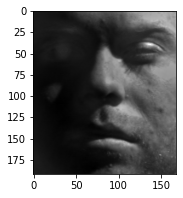

real data
 [[-0.91021566 -0.90863161 -0.90837238 ...  2.34643418  2.48146525
   2.65522016]
 [-0.89898376 -0.90807187 -0.90300192 ...  2.3007156   3.33523332
   3.42035519]
 [-0.90662025 -0.9158145  -0.92695741 ...  2.26987569  2.30271225
   2.42662535]
 ...
 [-0.82869798 -0.84497645 -0.83707632 ... -0.45605288 -0.34349626
  -0.29403508]
 [-0.77992784 -0.79582267 -0.80608888 ... -0.51472333 -0.34007941
  -0.15176829]
 [-0.79093069 -0.80362545 -0.83021299 ... -0.43614882 -0.1175365
   0.21892638]]


In [361]:
 def image_original_data_loadig(data_dic, lightings, people, image_size = 50, plotting = False, who = '02', each_row = 10):  

    lighting_class, person_class, count = -1, -1, 0
    elevation, azimuth = [], []

    image_test_data, image_train_data = [], []
    train_public_label, train_sensitive_label, image_train_labels = [], [], []
    test_public_label, test_sensitive_label, image_test_labels = [], [], [] #public: person,  private: lighting/angles
    print('Loading Image Database...')

    for lighting in lightings:
        lighting_class += 1
        person_class, train_count, plot_count = -1, 0, 0
        each_person = np.zeros(38)

        if plotting:
            print('%s:'%lighting)
            fig=plt.figure(figsize=(20,250))
            axes=[]
            people = [who]

        for person in people:
            person_class += 1
            folder = path + 'Image Dataset/CroppedYale/yaleB' + str(person) + '/'
            length = len(os.listdir(folder))
            
            for file in os.listdir(folder):
                
                if file.endswith(".pgm") and (file[-12:-7] in data_dic[lighting]['azimuth']) and (file[-7:-4] in data_dic[lighting]['elevation']):
                    
                    image = plt.imread(folder + file)
                    if image_size != 0:
                      image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

                    if not plotting:
                      image = image.reshape(-1)
                      if each_person[person_class] == 0:
                        image_train_data.append(image) # train data: one picture of each lighting per person
                        train_public_label.append(person_class)
                        train_sensitive_label.append(lighting_class)
                      else:
                        image_test_data.append(image) # train data: one picture of each lighting per person
                        test_public_label.append(person_class)
                        test_sensitive_label.append(lighting_class)

                      each_person[person_class] += 1
                      train_count += 1
                      count += 1
                    
                    if plotting: # get unique azimuth and elevation values
                      axes.append(fig.add_subplot(length/each_row, each_row, plot_count+1))
                      axes[-1].set_title(person + '_' + file[-12:-4])
                      axes[-1].set_axis_off()
                      plt.imshow(image, plt.cm.gray)       
                      plot_count += 1
                      elevation.append(file[-7:-4]) if file[-7:-4] not in elevation else None
                      azimuth.append(file[-12:-7]) if file[-12:-7] not in azimuth else None

                if plotting and plot_count == each_row:
                  fig.tight_layout()    
                  plt.show()
                  plot_count = 0
                  axes=[]
                  fig=plt.figure(figsize=(20,250))
        
        if plotting:
            fig.tight_layout()    
            plt.show()    
        else:
            print('%s total images\t %s %s train images \tImage shape:'%(count, train_count, lighting), image.shape, '\tmin # of pics per person %s'%(int(min(each_person))))

    if not plotting:
        image_test_data, image_train_data = np.array(image_test_data), np.array(image_train_data)
        image_train_data = np.transpose(image_train_data)
        image_train_data = zero_mean_unit_var(image_train_data)
        # image_train_data = image_train_data - np.mean(image_train_data, axis = 0)
        # print('training data shape: ', image_train_data.shape)
        image_test_data = np.transpose(image_test_data)
        image_test_data = zero_mean_unit_var(image_test_data)
        # image_test_data = image_test_data - np.mean(image_test_data, axis = 0)

        print('\ntraining data shape: ', image_train_data.shape)
        print('public    labels (index = 0):', train_public_label[:39])
        print('sensitive labels (index = 1):', train_sensitive_label[:39])
        print('\ntesting   data shape: ', image_test_data.shape)
        print('public    labels (index = 0):', test_public_label[:239])
        print('sensitive labels (index = 1):', test_sensitive_label[:239])

        # train data labels
        train_sensitive_label = np.array(train_sensitive_label).reshape(-1,1)
        train_public_label = np.array(train_public_label).reshape(-1,1)
        image_train_labels = np.concatenate((train_public_label, train_sensitive_label),axis = 1)
        # test data labels
        test_sensitive_label = np.array(test_sensitive_label).reshape(-1,1)
        test_public_label = np.array(test_public_label).reshape(-1,1)
        image_test_labels = np.concatenate((test_public_label, test_sensitive_label),axis = 1)

    return image_train_data, image_train_labels, image_test_data, image_test_labels


#  loading data
image_size = 0
plotting = False
image_train_data, image_train_labels, image_test_data, image_test_labels = image_original_data_loadig(data_dic, lightings, people, image_size, plotting, '38')

if not plotting:
  print('\nexample')
  if image_size != 0: 
    image = image_train_data[0].reshape(image_size,image_size)
  else:
    image = image_train_data[0].reshape(192, 168)
  fig=plt.figure(figsize=(3,3))
  plt.imshow(image, plt.cm.gray)
  plt.show()
  print('real data\n', image)

# **Image Classification**

Potential Problem: too many classes

**Controllable Invariance:** 

* We use a one-layer neural network for the encoder and a one-layer neural network for prediction. 
* The discriminator is a two-layer neural network with batch normalization. 
* The batch size is set to 16 and the hidden size is set to 100.


**The Variational Fair Autoencoder** (https://arxiv.org/pdf/1511.00830.pdf) also employed in a similar fashion by Li et al. (2014). (Learning Unbiased Features): https://arxiv.org/pdf/1412.5244.pdf. We had one hidden layer with 500, 400 units respectively for the z1 encoder, x decoder, and 300, 100 units respectively for the z2 encoder and z1 decoder.

**Learning Unbiased Features:** In the experiment we used the extended Yale B dataset, which contains faces of 38 people under various lighting conditions corresponding to light source from different directions. We created 5 groups of images, corresponding to light source in upper right, lower right, lower left, upper left and the front. For each group of images, we chose 1 image per person to form one domain for that lighting condition. In this way we had 5 domains with 5 × 38 = 190 images in total. All the other images (around 2000) are used for testing. The task is to recognize the identity of the person in image, i.e. a 38-way classification task. For this task, we did not use a validation set, but rather report the best result on test set to see where the limits of different models are.

In [362]:
# ============================================================================
#      variables
# ============================================================================

input_size = image_train_data.shape[1]
print('input size:', input_size)
label_index = 0
num_of_class = len(np.unique(image_train_labels[:,label_index]))

batch_size = 16
epochs = 55
learning_rate = 0.001
gamma = 1.0
weight = [1.0]*num_of_class 
hidden_size = [100,100,100]

print_every = 5
printing_result = True
iterates = 1

# ============================================================================
#    variable ends
# ============================================================================
test_accuracies = []

for iterate in range(iterates):
  print(iterate, 'Building Model...')
  # ============================================================================
  #      variables
  # ============================================================================

  # encoder = Encoder(input_size, hidden_size[0], nn.ReLU())
  # decoder = Decoder(hidden_size[0], num_of_class, hidden_size[1], nn.ReLU())
  # decoder = Discriminator(hidden_size[0], num_of_class, hidden_size) 
  # model = Combine_model(encoder, decoder)
  model = Decoder(input_size, num_of_class, hidden_size[1])

  # encoder = Encoder_CNN(1, hidden_size[0])
  # decoder = Decoder_CNN(hidden_size[0], num_of_class, hidden_size[1], 3, 1849920)
  # model = Combine_model(encoder, decoder)
  
  summary(model.float(), (1, input_size)) if iterate == 0 else None
  train_loader, valid_loader, test_loader = loading_data(image_train_data, image_train_labels, 0.1, 0.01, False, printing_result, False, False)

  test_x, test_y = torch.from_numpy(image_test_data).double(), torch.from_numpy(image_test_labels)
  test_ds = torchdata.TensorDataset(test_x, test_y)
  test_loader = torchdata.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

  # break
  # # ============================================================================
  #      variables ends
  # ============================================================================
  original_training(model, train_loader, valid_loader, label_index, gamma, weight, learning_rate, epochs, batch_size, print_every, printing_result)
  test_accuracies.append( original_testing(model, test_loader, label_index, printing_result, -1) )

print ('Average Test Accuracy:', sum(test_accuracies)/len(test_accuracies)) if len(test_accuracies) != 0 else None

input size: 32256
0 Building Model...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
             layer-1                  [-1, 100]       3,225,700
             layer-2                   [-1, 38]           3,838
Total params: 3,229,538
Trainable params: 3,229,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.00
Params size (MB): 12.32
Estimated Total Size (MB): 12.44
----------------------------------------------------------------
Loading Dataset...
   train dataset: (190, 32256) (190, 2)

Training...  Label: 0
Epoch: 1/55
loss: 3502.0192234526735
loss: 3243.4419954291952
loss: 1699.9579177993844
Training Accuract: 0.031578947368421054
Epoch: 2/55
loss: 1697.3975313356464
loss: 1733.4722233883479
Training Accuract: 0.06842105263157895
Epoch: 3/55
loss: 1624.89858714713
loss: 1823.6173150051047
loss: 1085.1

In [ ]:
class Encoder_CNN(nn.Module):
    def __init__(self, input_channel = 10, num_filters = 1, kernel_size = 3):
        super(Encoder_CNN, self).__init__()
        
        # layers (CNN)
        self.C1 = nn.Conv2d(input_channel, num_filters, kernel_size=kernel_size)


    def forward(self, X):
        o = self.C1(X)
        return o

    def flatten(self, x):
        # print (x.size())
        B, _, _, _ = x.size()
        return x.contiguous().view(B,-1)

class Decoder_CNN(nn.Module):
    def __init__(self, input_dim = 1, output_dim = 3, num_filters = 1, kernel_size = 3, linear_input = 924960):
        super(Decoder_CNN, self).__init__()
        
        # layers (CNN)
        self.C1 = nn.Conv2d(input_dim, num_filters, kernel_size=kernel_size)
        self.L1 = nn.Linear(linear_input, output_dim)
        self.a1 = nn.Sigmoid()
        
    def forward(self, X):
        self.z = self.C1(X)
        self.z = self.a1(self.z)
        self.z = self.flatten(self.z)
        # print(self.z.size())
        self.z = self.L1(self.z)
        o = self.z
        return o

    def flatten(self, x):
        # print (x.size())
        B, _, _, _ = x.size()
        return x.contiguous().view(B,-1)

class Discriminator_CNN(nn.Module):
    def __init__(self, input_dim = 1, output_dim = 3, hidden_filters = 1, num_filters = 1, kernel_size = 3, linear_input = 451980):
        super(Discriminator_CNN, self).__init__()
    
        # layers (CNN)
        self.C1 = nn.Conv2d(input_dim, hidden_filters, kernel_size=kernel_size)
        self.BN = nn.BatchNorm2d(hidden_filters)
        self.C2 = nn.Conv2d(hidden_filters, num_filters, kernel_size=kernel_size)
        self.L1 = nn.Linear(linear_input, output_dim)

    def forward(self, X):
        self.z = self.C1(X)
        self.z = self.BN(self.z)
        self.z = self.C2(self.z)
        self.z = F.relu(self.z)
        self.z = self.flatten(self.z)
        self.z = self.L1(self.z)
        o = self.z
        return o

    def flatten(self, x):
        # print (x.size())
        B, N, _, _ = x.size()
        return x.contiguous().view(B,-1)